In [2]:
# import all tensorflow and keras
import numpy as np 
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,MaxPool2D
from keras.layers import Conv2D, Reshape

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D


In [3]:
import os
import cv2
from skimage import io
from PIL import Image

# Cropping All The Images

In [5]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours and cut out the unnecessary backgrounds
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        
        plt.subplot(1, 3, 3)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 3, 3)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In [9]:
# Define the paths in directory
train_path = 'C:\\Users\\Home\\ CAPS project\\Augmented'
test_path = 'C:\\Users\\Home\\ CAPS project\\Testing'

In [65]:
# logic to rename the files IN MY DIRECTORY
path_dir = 'C:\\Users\\Home\\ CAPS project\\Augmented\\aug_pituitary'
all_files = os.listdir(path_dir)

cnt = 0
for images in all_files:
    old_name = os.path.join(path_dir, images)
    new_name = os.path.join(path_dir, str(cnt) + 'pp'+'.jpg')
    src = old_name
    os.rename(src,new_name)
    cnt+=1
    
    

In [11]:
def load_datar(dir_list, image_size):
   

    W = [] # Holds the image array
    m = [] # Holds the image labels
    #directory = train_path 
    image_width, image_height = image_size
    
    for directory in dir_list:
        for file in listdir(directory):
            image = cv2.imread(directory + '\\' + file)
            # cropping process
            image = crop_brain_contour(image, plot = False)
            image = cv2.resize(image, dsize = (image_width , image_height),
                               interpolation =cv2.INTER_CUBIC)
            # normalize by scaling pizels down  by 255
            image = image/255
            # convert to an array and add it to the list 
            W.append(image)
            ## Add number to the image lables array
            if directory[-5:] == 'lioma': # create numerical labels for the Tumor type
                m.append([1])
            elif directory[-5:] == 'gioma':
                m.append([2])
            elif directory[-9:] == 'pituitary':
                m.append([3])
            else:
                m.append([0])    
            
    # Make into a numpy array    
    W = np.array(W) 
    m = np.array(m)
        
    ## Shuffle the Data
    W,m = shuffle(W,m)

    print(f'No. of training ex. : {len(W)} images')
    print(f'W shape is: {W.shape}')
    print(f'm shape is: {m.shape}')

    return W, m



In [12]:
## Use the function to apply cropping and load images into lists
augmented_path = 'C:\\Users\\Home\\ CAPS project\\Augmented\\'
aug_glioma = augmented_path + 'aug_glioma'
aug_meningioma = augmented_path + 'aug_meningioma'
aug_no = augmented_path + 'aug_no'
aug_pituitary = augmented_path + 'aug_pituitary' 
aug_all = augmented_path + 'aug_all'
IMG_W , IMG_H = (150,150)
## Use the function
W, m = load_datar([aug_glioma, aug_meningioma, aug_pituitary, aug_no], (IMG_W,IMG_H))


No. of training ex. : 3265 images
W shape is: (3265, 150, 150, 3)
m shape is: (3265, 1)


# Plot the Sample images 

In [40]:
def plot_images(W, m):
## loop through all the labels in the range [0,3]
## use images instead of image
    
    n = int(input("How many Cropped images do you want plotted?"))
    
    for label in [0,1,2,3]:
        images = W[np.argwhere(m == label)] # matches label to image
        n_images = images[:n]
        
        ## generate the row and column diplay
        column_n = 10
        row_n = int(n/column_n)
        ## use plt to show picture
        plt.figure(figsize = (25,10))
        
        i = 1
        
        for image in n_images:
            plt.subplot(row_n, column_n, i)
            plt.imshow(image[0])
            # remove all the gridlines and ticks
            plt.tick_params(axis='both', which='both', 
                    top=False, bottom=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            # increment to next plot
            i +=1
        
        ## Generate the headings of the plot
        
        #label_to string = lambda label: "Glioma" if label == 1
           
        if label == 0:  
            plt.suptitle("Brain Tumor : None")
        elif label == 1:
            plt.suptitle("Brain Tumor: Glioma")
        elif label == 2: 
            plt.suptitle("Brain Tumor: Meningioma")
        elif label == 3:
            plt.suptitle("Brain Tumor: Pituitary")
        else:
            print("This is not a valid label")
        
    
        plt.show()

How many Cropped images do you want plotted?40


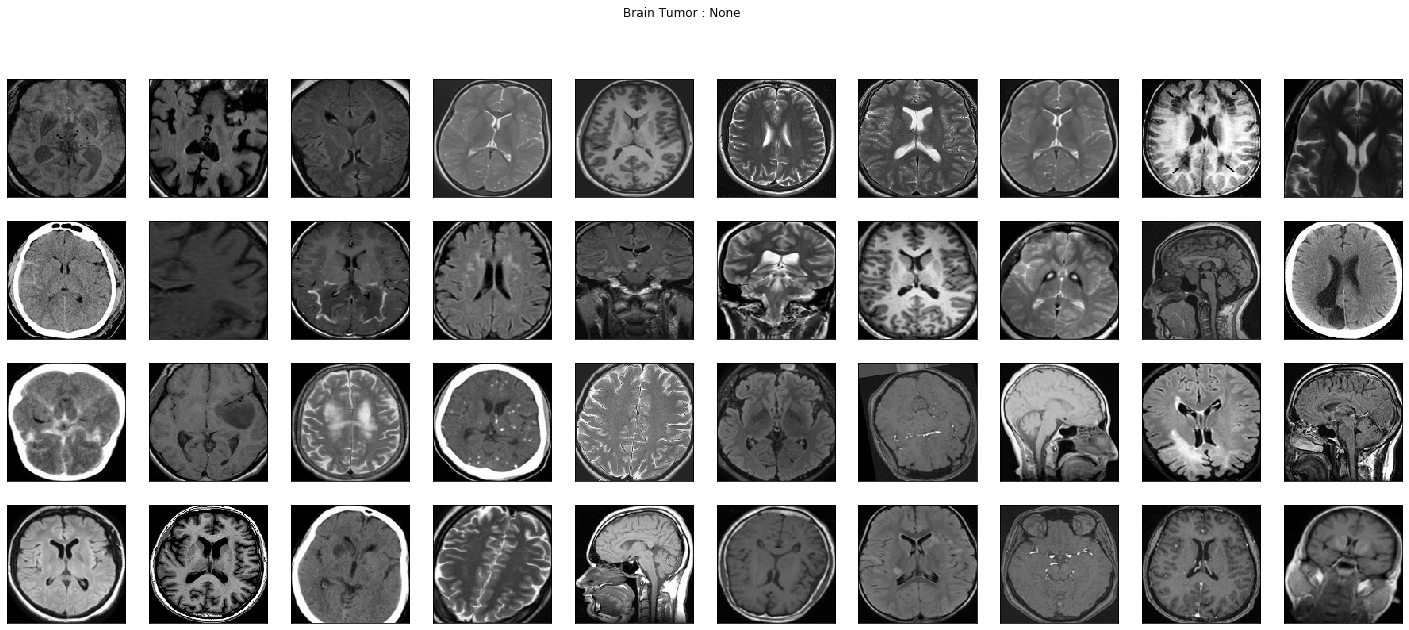

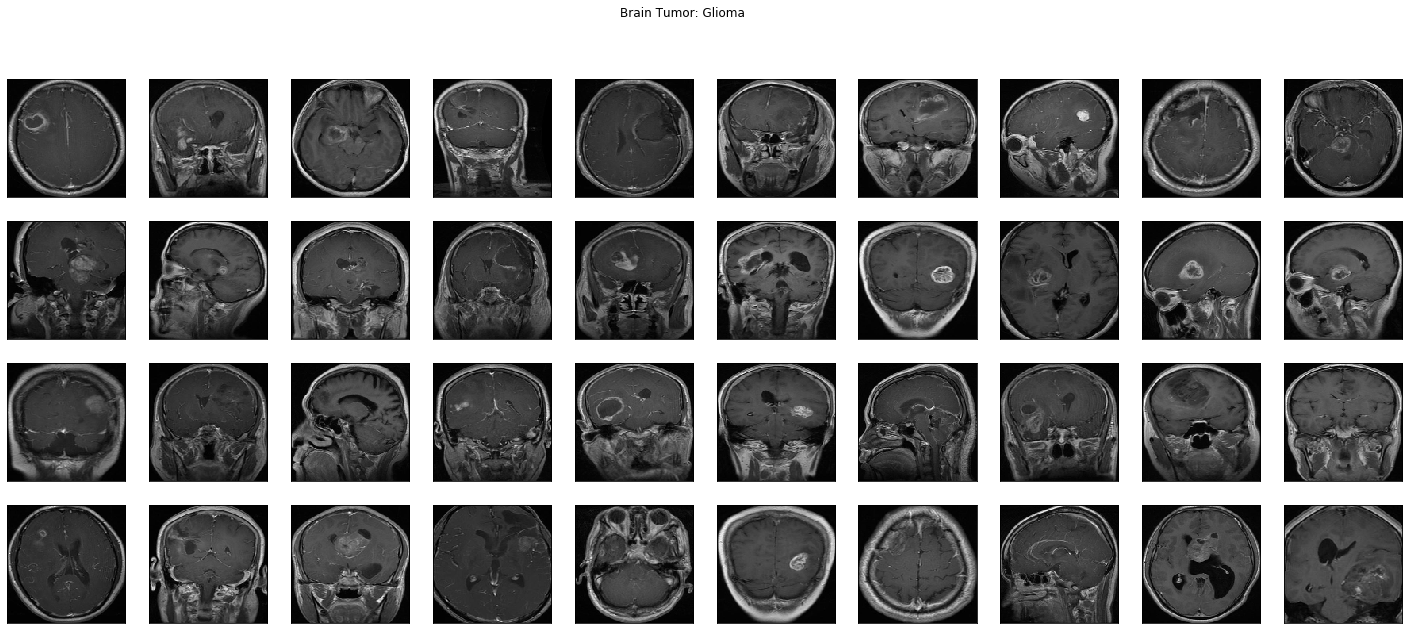

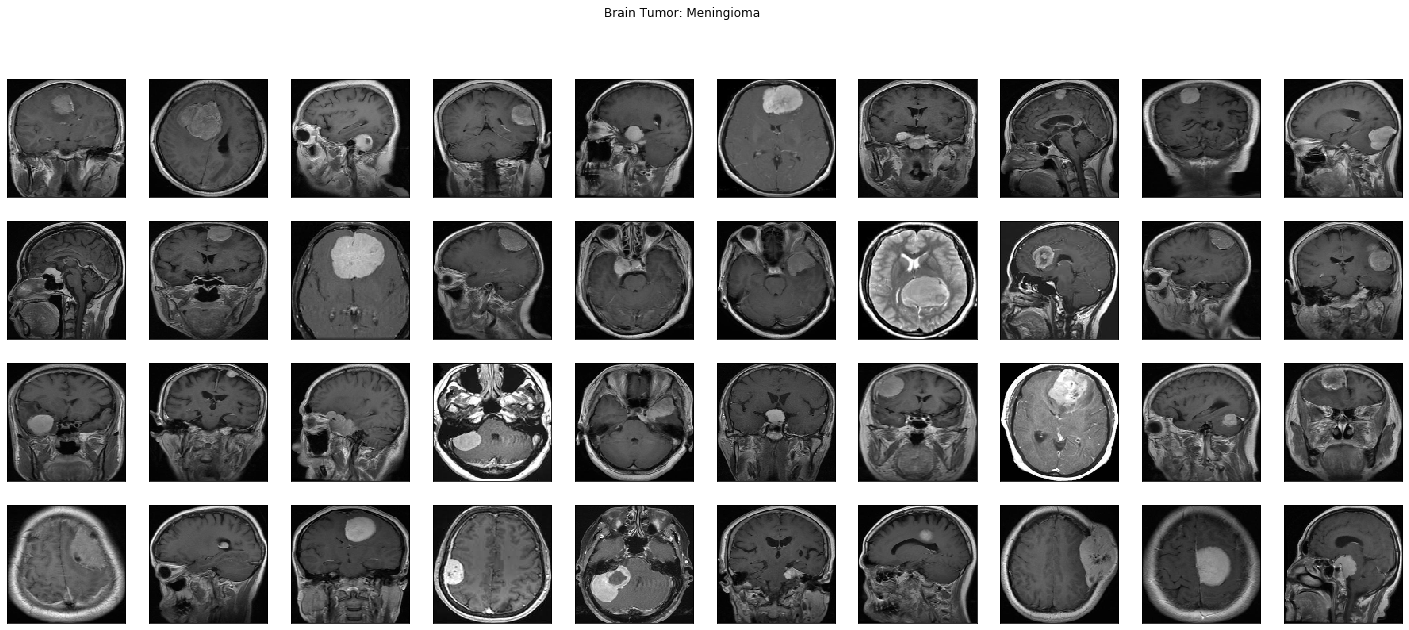

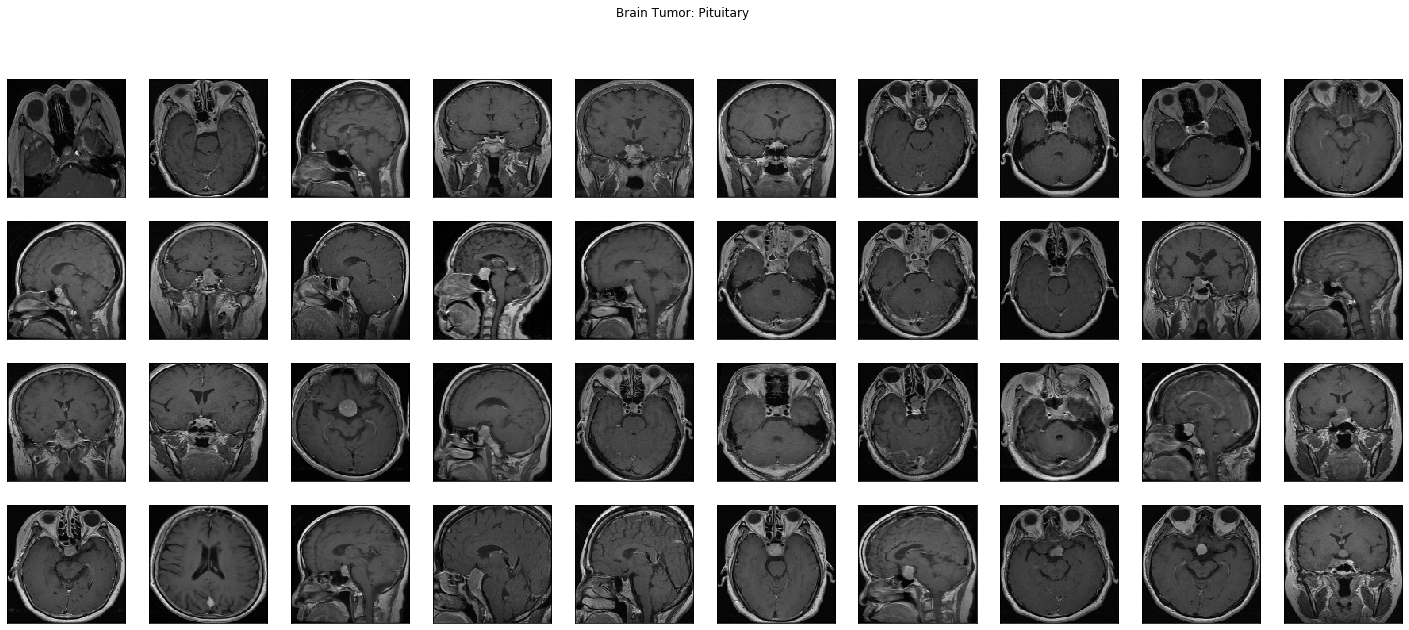

In [41]:
plot_images(W,m) # prompts user to input how many images of each class they want printed, in this case 40. 

In [42]:
def hms_string(sec_elapsed): ## Time String, not really used for now
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [57]:
def split_data(W,m,test_size = .1): # Train_test split from keras and scikit imaging
    
    W_train, W_test , m_train, m_test = train_test_split(W,m,test_size = test_size)
    W_test, W_val, m_test, m_val = train_test_split(W_test, m_test, test_size=0.2)
    
    return W_train,m_train,W_val,m_val, W_test, m_test

In [184]:
 W_train, m_train ,W_val ,m_val , W_test, m_test = split_data(W,m,test_size = .1)
    ## create a validation dataset

In [283]:
## prints the overview of Data
print(f"Training Examples = {W_train.shape[0]}")
print(f"Validation Examples = {W_val.shape[0]}")
print(f"Testing Examples = {W_test.shape[0]}")

print(f"Training data shape = {W_train.shape}")
print(f"Testing data shape = {W_test.shape}")
print(f"Validation data shape = {W_val.shape}")

Training Examples = 2938
Validation Examples = 66
Testing Examples = 261
Training data shape = (2938, 150, 150, 3)
Testing data shape = (261, 150, 150, 3)
Validation data shape = (66, 150, 150, 3)


In [169]:
## Skip this and go to next block- it doesent matter for now
def model_architecture(input_shape) : 
    
    inp = Input(shape = (input_shape))
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu',input_shape= (input_shape))
    model.add(MaxPooling2D( pool_size= (2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(.1))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.1))
    model.add(Dense(256 , activation = 'relu'))
    model.add(BatchNormalization(axis= -1))
    model.add(Dropout(0.1))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model = Model(inputs = inp, outputs = out, name = 'BrainDataDetectionModel') 
    return model
    print(model.summary())

SyntaxError: invalid syntax (<ipython-input-169-715867213895>, line 6)

# Attempting to build the model

I don't fully understand the Architecture of building a Keras Sequential model but this is what I've got.

In [295]:
def build_model(input_shape):
    
    
    W_input = Input(shape = input_shape) # shape=(?, 150, 150, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    W = ZeroPadding2D((2, 2))(W_input) # shape=(?, 154, 154, 3)
    
    # CONV -> BN -> RELU Block applied to X
    W = Conv2D(32, (7, 7), strides = (4, 4), name = 'conv0')(W)
    
    W = Activation('relu')(W) # shape=(?, 138, 138, 32)
    
    # MAXPOOL 1
    W = MaxPooling2D((2, 2), strides = (1,1), name='max_pool0')(W) # shape=(?, 69, 69, 32) 
    W = BatchNormalization(axis = 3, name = 'bn0')(W)
    W = Dropout(rate = 0.1)(W)
  
    #Second conv layer
    W = Conv2D(32, (7, 7), strides = (4, 4), activation = 'relu',name = 'conv1')(W)
    
    # MAXPOOL 2
    W = MaxPooling2D((2, 2), name='max_pool1')(W) # shape=(?, 15, 15, 32)
    W = MaxPooling2D((2,2), name = 'max_pool2')(W) # shape =(?,5,5,32)
    W = BatchNormalization(axis = 3, name = 'bn1')(W)
    W = Dropout(rate = 0.2)(W)
    
    
    # FLATTEN X 
    W = Flatten()(W) # shape=(?, 3694)
    
    # Dense Layers
    
    # Fully connected
    W = Dense(4, input_shape = (150,),activation='softmax', name='ConnectionFinal')(W) # shape=(?, 1)
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = W_input, outputs = W, name='BrainDetectionCNNModel')
    
    model.summary()
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

# The above is where the problem lies I think, specifically on the last Dense Layer. The number (4) associates with the number of classes of Tumors and that's why its in the output nodes

In [237]:
from keras.utils import to_categorical ## this function may help in solving the problem but I haven't solved it with it yet.

In [267]:
#Ignore- 
#m_train = to_categorical(m_train, 4)
#m_test = to_categorical(m_test, 4)

In [296]:
img_shape = (150,150,3)
model = build_model(img_shape) ## getting a summary of the Convolutional Neural Network model

Model: "BrainDetectionCNNModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
zero_padding2d_37 (ZeroPaddi (None, 154, 154, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 37, 37, 32)        4736      
_________________________________________________________________
activation_37 (Activation)   (None, 37, 37, 32)        0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 36, 36, 32)        0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 36, 36, 32)        128       
_________________________________________________________________
dropout_67 (Dropout)         (None, 36, 36, 

In [265]:
type(model)

tensorflow.python.keras.engine.functional.Functional

In [273]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_accuracy', patience=3, )
import time
from keras.utils import to_categorical 

In [293]:
# Here is where the error occurs: I've read that one hot encoding would potentially solve the issue, but I dont know how to implement it in the build_model function
history = model.fit(W_train, m_train, batch_size = 75, verbose = 1, epochs = 10, validation_data = (W_val, m_val), callbacks = [callback], shuffle = False)



Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 1.1495 - accuracy: 0.5323

ValueError: in user code:

    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 test_function  *
        return step_function(self, iterator)
    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1208 run_step  **
        outputs = model.test_step(data)
    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1177 test_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\Home\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 4) are incompatible


In [ ]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
